In [25]:
from Bio.PDB.PDBParser import PDBParser
import numpy as np

In [2]:
parser = PDBParser()

In [3]:
struc = parser.get_structure("2", "./data/alanine_dipeptide/2.pdb")

/home/jak/.conda/envs/py/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 22
  warnings.warn(


In [4]:
residues = list(struc.get_residues())
residues

[<Residue ALA het=  resseq=1 icode= >, <Residue ALA het=  resseq=2 icode= >]

In [5]:
res = residues[0]

In [6]:
res

<Residue ALA het=  resseq=1 icode= >

In [7]:
atoms = list(res.get_atoms())

In [8]:
atoms

[<Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>,
 <Atom CB>,
 <Atom H>,
 <Atom HA>,
 <Atom 1HB>,
 <Atom 2HB>,
 <Atom 3HB>]

In [9]:
a = atoms[0]

In [10]:
v = a.get_vector()

In [11]:
v.angle(atoms[1].get_vector())

1.3475739258740307

In [79]:
coords = list()
for res in struc.get_residues():
    atoms = np.concatenate([a.coord for a in res.get_atoms() if a.name in {"N", "CB", "C", "H", "CA"}]).reshape(-1,3)
    coords.append(atoms)

In [80]:
coords

[array([[-6.770e-01, -1.230e+00, -4.910e-01],
        [-1.000e-03,  6.400e-02, -4.910e-01],
        [ 1.499e+00, -1.100e-01, -4.910e-01],
        [-5.090e-01,  8.560e-01,  7.270e-01],
        [-1.310e-01, -2.162e+00, -4.910e-01]], dtype=float32),
 array([[ 2.25 ,  0.939, -0.479],
        [ 3.7  ,  0.77 , -0.479],
        [ 4.4  ,  2.108, -0.464],
        [ 4.207, -0.035,  0.731],
        [ 1.841,  1.862, -0.47 ]], dtype=float32)]

In [66]:
import matplotlib.pyplot as plt

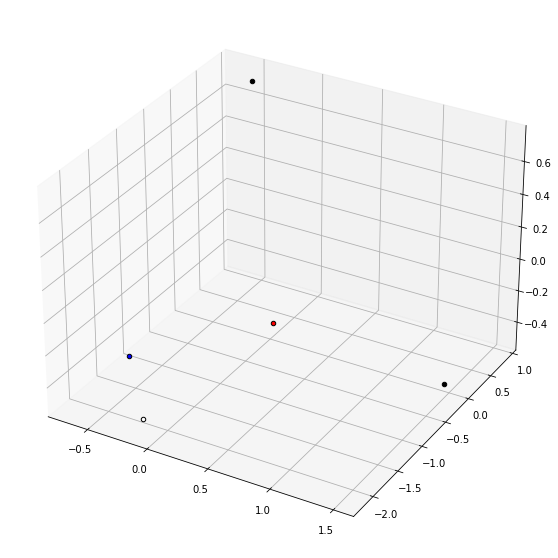

In [70]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

ax.scatter(*coords[0]['H'], color='w', ec='k')
ax.scatter(*coords[0]['C'], color='k', ec='k')
ax.scatter(*coords[0]['N'], color='b', ec='k')
ax.scatter(*coords[0]['CB'], color='k', ec='k')
ax.scatter(*coords[0]['CA'], color='r', ec='k')

In [91]:
res1 = coords[0]

In [92]:
to_origin = res1 - res1[1]
to_origin

array([[-0.676    , -1.294    ,  0.       ],
       [ 0.       ,  0.       ,  0.       ],
       [ 1.5      , -0.174    ,  0.       ],
       [-0.508    ,  0.792    ,  1.2179999],
       [-0.13     , -2.2259998,  0.       ]], dtype=float32)

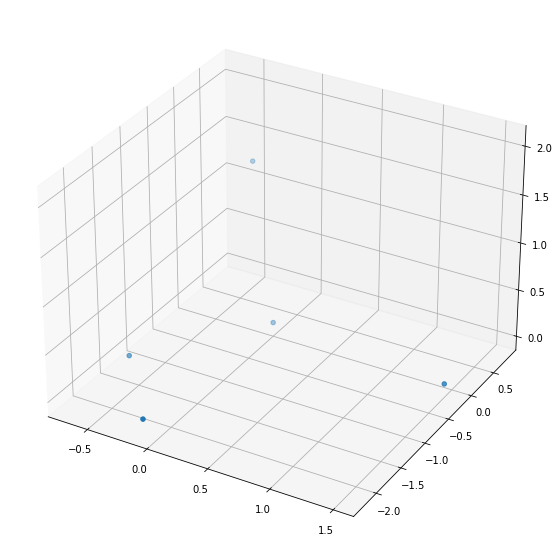

In [119]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

ax.scatter(*to_origin.T)
cp = np.cross(to_origin[0], to_origin[2])
ax.plot(*cp.T, color='r')

In [124]:
h = to_origin[-1]

    |cos θ   −sin θ   0| |x|   |x cos θ − y sin θ|   |x'|
    |sin θ    cos θ   0| |y| = |x sin θ + y cos θ| = |y'|
    |  0       0      1| |z|   |        z        |   |z'|
    
    | cos θ    0   sin θ| |x|   | x cos θ + z sin θ|   |x'|
    |   0      1       0| |y| = |         y        | = |y'|
    |−sin θ    0   cos θ| |z|   |−x sin θ + z cos θ|   |z'|
    
    |1     0           0| |x|   |        x        |   |x'|
    |0   cos θ    −sin θ| |y| = |y cos θ − z sin θ| = |y'|
    |0   sin θ     cos θ| |z|   |y sin θ + z cos θ|   |z'|

In [129]:
h[1], h[2]

(-2.2259998, 0.0)

In [136]:
theta = np.arctan2(h[1], h[2])

In [138]:
rotator = np.array([[1,0,0],[0,np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])

In [141]:
rotator @ h.reshape(-1,1)

array([[-1.29999995e-01],
       [ 9.73015430e-08],
       [ 2.22599983e+00]])

In [145]:
def get_theta(vec):
    return np.arctan2(vec[1], vec[2])

def get_phi(vec):
    return np.arctan2(-vec[0], vec[2])

In [146]:
theta = get_theta(h)
print(f"{theta=}")

phi = get_phi(h)
print(f"{phi=}")

theta=-1.5707964
phi=1.5707964


In [147]:
def rotate_x(theta):
    sin = np.sin(theta)
    cos = np.cos(theta)
    
    M = np.array([[1,0,0],[0, cos, -sin], [0, sin, cos]])
    return M

def rotate_y(phi):
    sin = np.sin(phi)
    cos = np.cos(phi)
    
    M = np.array([[cos, 0, sin],[0,1,0], [-sin, 0, cos]])
    return M

In [152]:
rotate_x(theta) @  h

array([-1.29999995e-01,  9.73015430e-08,  2.22599983e+00])

In [153]:
rotate_y(phi) @ h

array([ 5.68248027e-09, -2.22599983e+00,  1.29999995e-01])

In [155]:
new_h = rotate_x(get_theta(h)) @ h
new_h

array([-1.29999995e-01,  9.73015430e-08,  2.22599983e+00])

In [156]:
rotate_y(get_phi(new_h)) @ new_h

array([3.44840348e-18, 9.73015430e-08, 2.22979265e+00])

In [164]:
def get_rotator(h):
    theta = get_theta(h)
    intermediate = rotate_x(theta) @ h
    phi = get_phi(intermediate)
    result = rotate_y(phi) @ intermediate
    
    factor = -1 if result[2] >= 0 else 1
    
    M = factor * rotate_y(phi) @ rotate_x(theta)
    return M

In [165]:
rotator = get_rotator(h)
rotator

array([[-9.98299028e-01,  5.83013830e-02,  2.54843439e-09],
       [ 0.00000000e+00,  4.37113883e-08, -1.00000000e+00],
       [ 5.83013830e-02,  9.98299028e-01,  4.36370364e-08]])

In [170]:
rotated = (rotator @ to_origin.T).T

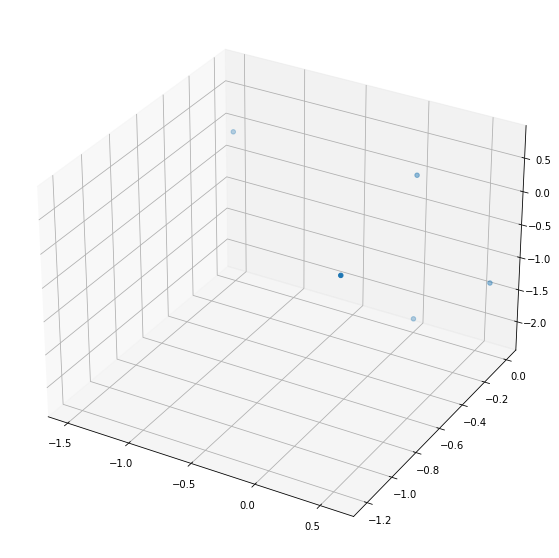

In [171]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

ax.scatter(*rotated.T)

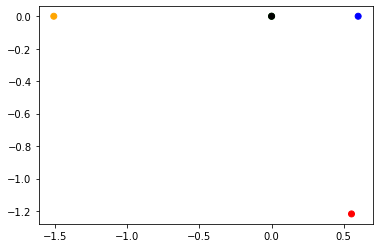

In [187]:
plt.scatter(*rotated[:, :2].T, c=["blue", "green", "orange", "red", "black"])

In [204]:
for vec in rotated[:,:2]:
    vec[abs(vec) < 1e-7] = 0
    vec[1], vec[0] = vec[0], vec[1]
    print(np.arctan2(*vec))

0.7853981633974483
0.0
3.141592653589793
-1.1443904715658828
0.0


In [247]:
result = dict()
for n, res in enumerate(struc.get_residues()):
    atoms = {atom.name:atom.coord for atom in res.get_atoms()}
    h_vec = atoms['H'] - atoms['CA'] # centering
    rotator = get_rotator(h_vec)
    rotate_side = rotator @ (atoms['CB'] - atoms['CA'])
    
    if rotate_side[1] < 0:
        result[n] = "L"
    elif rotate_side[1] > 0:
        result[n] = "D"
    else:
        raise ValueError
result

{0: 'L', 1: 'D'}

In [248]:
import yaml

In [249]:
with open('./data/alanine_dipeptide/config.yaml') as f:
    config = yaml.safe_load(f)
config

{1: {'amide': 'trans', 'stereo': ['L', 'L']},
 2: {'amide': 'trans', 'stereo': ['L', 'D']},
 3: {'amide': 'trans', 'stereo': ['D', 'L']},
 4: {'amide': 'trans', 'stereo': '-D -D'},
 5: {'amide': 'cis', 'stereo': ['L', 'L']},
 6: {'amide': 'cis', 'stereo': ['L', 'D']},
 7: {'amide': 'cis', 'stereo': ['D', 'L']},
 8: {'amide': 'cis', 'stereo': ['D', 'D']}}

In [251]:
config[1]['stereo']

['L', 'L']

In [250]:
type(struc)

Bio.PDB.Structure.Structure

>


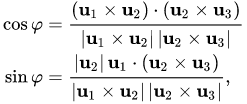!

In [327]:
struc = parser.get_structure("2", "./data/alanine_dipeptide/2.pdb")
atoms = [a for a in struc.get_atoms() if a.name in {"N", "CA", "C", "O"}]
atoms

/home/jak/.conda/envs/py/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 22
  warnings.warn(


[<Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>,
 <Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>]

In [328]:
c = atoms[2]
o = atoms[3]
n = atoms[4]
ca = atoms[5]

u1 = o.coord - c.coord
u2 = n.coord - c.coord
u3 = ca.coord - n.coord

cl = np.cross(u1, u2)
cr = np.cross(u2, u3)

In [329]:
np.arccos(np.dot(cl, cr) / np.dot(np.linalg.norm(cl),np.linalg.norm(cr)))

3.1415927

In [330]:
struc = parser.get_structure("5", "./data/alanine_dipeptide/5.pdb")
atoms = [a for a in struc.get_atoms() if a.name in {"N", "CA", "C", "O"}]
atoms

/home/jak/.conda/envs/py/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 22
  warnings.warn(


[<Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>,
 <Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>]

In [331]:
c = atoms[2]
o = atoms[3]
n = atoms[4]
ca = atoms[5]

u1 = o.coord - c.coord
u2 = n.coord - c.coord
u3 = ca.coord - n.coord

cl = np.cross(u1, u2)
cr = np.cross(u2, u3)

In [332]:
np.arccos(np.dot(cl, cr) / np.dot(np.linalg.norm(cl),np.linalg.norm(cr)))

0.00077204045